In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Setup models to use and needed parameters for model selection
testSize = 0.25 #percentage of total set
k = 5 # for K-fold cross-validation
GBC = GradientBoostingClassifier()
RFC = RandomForestClassifier()
DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier()
linear = LogisticRegression()
models = [('Linear',linear,RFE(linear)),
          ('Gradient Boosting', GBC, SelectFromModel(GBC)),
          ('Random Forests',RFC,SelectFromModel(RFC)),
          ('Decision tree',DTC,SelectFromModel(DTC)),
          ('Adaboost',ABC,SelectFromModel(ABC))]

In [3]:
# load the data
X = pd.read_csv("../multiclass/X.csv",header=None).values
y = pd.read_csv("../multiclass/y.csv",header=None,squeeze=True).values
waveLengths = pd.read_csv("../multiclass/Wavelength.csv",header=None)
X_toClassify = pd.read_csv("../multiclass/XtoClassify.csv",header=None).values
# Put aside data for testing at the end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)


# Do some standard normalisation
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_toClassify = scaler.transform(X_toClassify)

In [4]:
# Get a baseline accruaccy
linear = LogisticRegression()
linear_selector = RFE(linear)
linear.fit(X_train,y_train)
f1_score(linear.predict(X_train),y_train,average='micro')

1.0

In [5]:
# Setup a dataframe to contain the results
results = pd.DataFrame(columns=['Algorithm',
                                'Mean score',
                                'Total operation time',
                                'Number of important features',
                                "Feature set"])

# Loop over the models and test their performance using cross validation and the f1 score
for name, model, selector in models:
    scores = cross_validate(model,X_train,y_train,cv=k,scoring='f1_micro')
    
    # Can we do just as well with fewer features?
    selector.fit(X_train,y_train)
    X_reduced = selector.transform(X_train)
    scores_reduced = cross_validate(model,X_reduced,y_train,cv=k,scoring='f1_micro')

    results.loc[len(results)] = pd.Series({
        'Algorithm' : name,
        "Mean score":scores['test_score'].mean(),
        "Total operation time" : sum(scores['fit_time'])+sum(scores['score_time']),
        "Number of important features":sum(selector.get_support()),
        "Feature set" : "Full"})
    results.loc[len(results)] = pd.Series({
        'Algorithm' : name,
        "Number of important features":sum(selector.get_support()),
        "Mean score":scores_reduced['test_score'].mean(),
        "Total operation time" : sum(scores_reduced['fit_time'])+sum(scores_reduced['score_time']),
        "Feature set":"reduced"})                                                                                                                                                 
    


# calculate the 'rating' to determine the best model. Based on accuracy and operation time. Higher is better 
results['Rating'] = results['Mean score'] /results['Total operation time']
results.sort_values('Rating',ascending=False,inplace=True)
bestModelRecord = results.iloc[0]
results

,Algorithm,Mean score,Total operation time,Number of important features,Feature set,Rating
7,Decision tree,1.000000,0.011247,4,reduced,88.909465
5,Random Forests,1.000000,0.154518,39,reduced,6.471733
4,Random Forests,1.000000,0.264589,39,Full,3.779449
6,Decision tree,1.000000,0.698857,4,Full,1.430908
1,Linear,1.000000,0.872303,460,reduced,1.146391
9,Adaboost,0.803965,1.141061,38,reduced,0.704577
0,Linear,1.000000,1.761972,460,Full,0.567546
3,Gradient Boosting,0.990905,3.890225,85,reduced,0.254717
8,Adaboost,0.897433,13.008642,38,Full,0.068987
2,Gradient Boosting,0.990905,24.745956,85,Full,0.040043


In [6]:
# Find the best model
for name,model,selector in models:
    if name == bestModelRecord['Algorithm']:
        bestModel = model
        bestSelector = selector
        
# Train the best model on the reduced feature set and report the accuracy
bestModel.fit(bestSelector.fit_transform(X_train,y_train),y_train)
f1_score(bestModel.predict(bestSelector.transform(X_test)),y_test,average='micro')

1.0

In [7]:
# Use trained model to predict and store the results of the samples to classify
# Note that X_toClassify was already normalised
pd.DataFrame(bestModel.predict(bestSelector.transform(X_toClassify))).to_csv("../multiclass/PredictedClasses.csv",index=False)

In [8]:
# Put the best features and the labels in one dataframe so we can easily plot them
bestFeatures = bestSelector.get_support()
df = pd.concat([
        pd.DataFrame(X[:,bestFeatures],columns=["{:.3f}".format(numb) + " nm" for wl in waveLengths[bestFeatures].values.tolist() for numb in wl ]),
        pd.DataFrame(y,columns=["Catagory"])]
    ,axis=1)
df.head()

,535.923 nm,557.413 nm,618.899 nm,729.516 nm,Catagory
0,30.37,24.03,10.27,12.63,1
1,8.04,8.91,37.85,65.61,2
2,52.49,57.30,60.43,57.43,4
3,2.91,3.49,36.69,37.45,3
4,1.93,1.22,1.86,-9.65,0


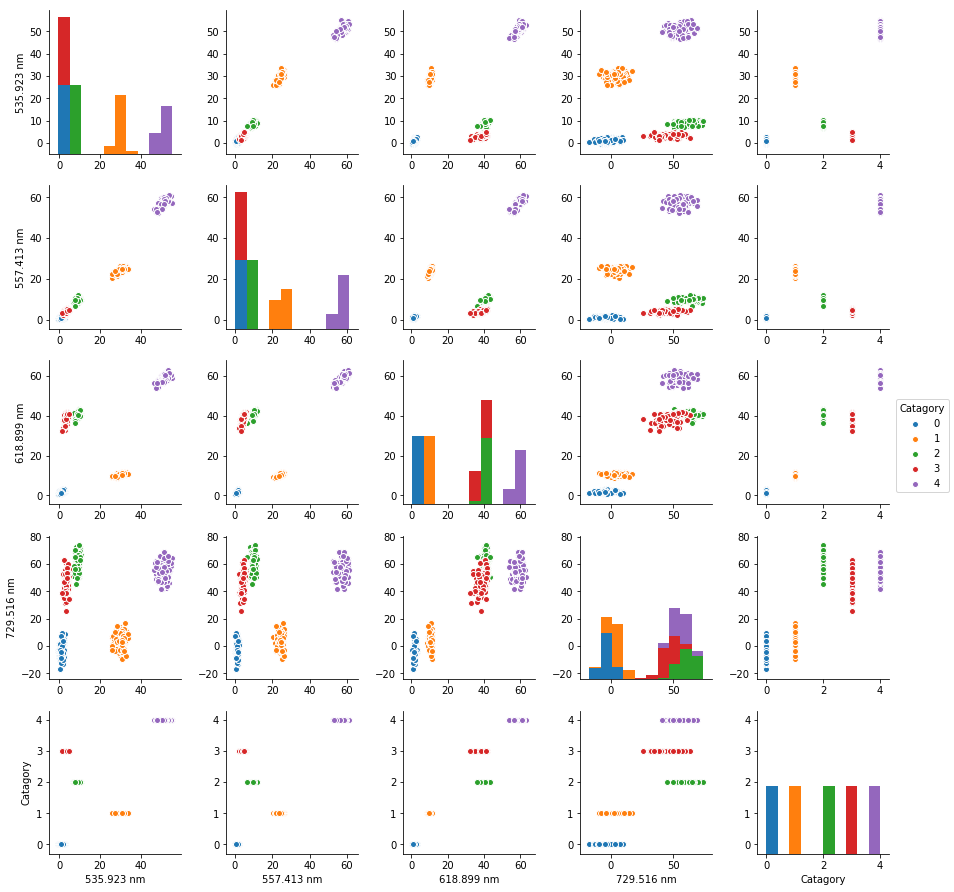

In [9]:
sns.pairplot(df,hue='Catagory')
plt.savefig('../tex/multiclassScatterplot.png')
plt.show()

In [10]:
print(results.to_latex())

\begin{tabular}{llrrllr}
\toprule
{} &          Algorithm &  Mean score &  Total operation time & Number of important features & Feature set &     Rating \\
\midrule
7 &      Decision tree &    1.000000 &              0.011247 &                            4 &     reduced &  88.909465 \\
5 &     Random Forests &    1.000000 &              0.154518 &                           39 &     reduced &   6.471733 \\
4 &     Random Forests &    1.000000 &              0.264589 &                           39 &        Full &   3.779449 \\
6 &      Decision tree &    1.000000 &              0.698857 &                            4 &        Full &   1.430908 \\
1 &             Linear &    1.000000 &              0.872303 &                          460 &     reduced &   1.146391 \\
9 &           Adaboost &    0.803965 &              1.141061 &                           38 &     reduced &   0.704577 \\
0 &             Linear &    1.000000 &              1.761972 &                          460 &        F